最近开始学习pandas用来进行数据分析的入门，这里将一些东西总结为一个notebook以方便查看。

## 下载数据

In [1]:
# TODO

In [2]:
%matplotlib inline

In [3]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import seaborn as sns # 引入seaborn让图表更现代

## 分析网页请求数据

In [4]:
import json
# 数据来源: http://1usagov.measuredvoice.com/2013/
with open('usagov_bitly_data2013-05-17-1368832207') as fp:
    records = map(json.loads, fp)

In [5]:
data = DataFrame(records) # 以frame形式使用数据

clean_tz = data['tz'].fillna('Missing')
clean_tz[clean_tz == ''] = 'Unknown'

# data[(data['tz'] == '') & (data['al'] == 'en')] # filter data

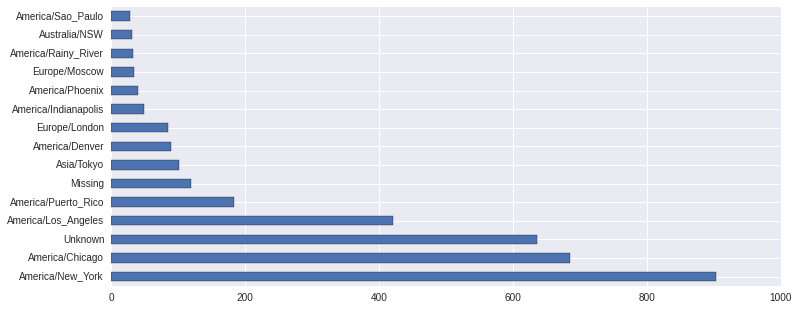

In [6]:
clean_tz.value_counts()[:15].plot(kind='barh', figsize=(12, 5)) # figsize 调整大小，单位为inch

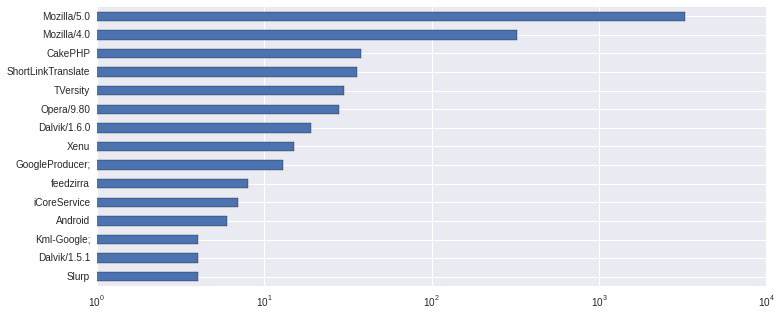

In [7]:
agents = Series([x.split(' ', 1)[0] for x in data.a.dropna()])
agents.value_counts(ascending=True)[-15:].plot(kind='barh', figsize=(12, 5), logx=True) # logx=True 使用对数坐标

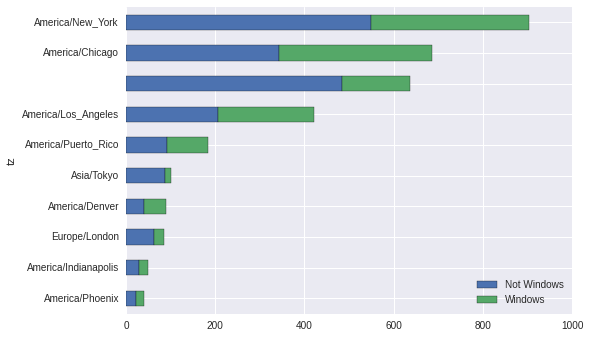

In [8]:
# 找出Windows和非Windows用户的比例
cframe = data[data.a.notnull()] # 过滤

operating_systems = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

by_tz_os = cframe.groupby(['tz', operating_systems])
agg_counts = by_tz_os.size().unstack().fillna(0)
# 排序
indexer = agg_counts.sum(1).argsort()
indexer[:10] # 最前面10个数据
count_subset = agg_counts.take(indexer)[-10:] # 最后10个数据
count_subset.plot(kind='barh', stacked=True)

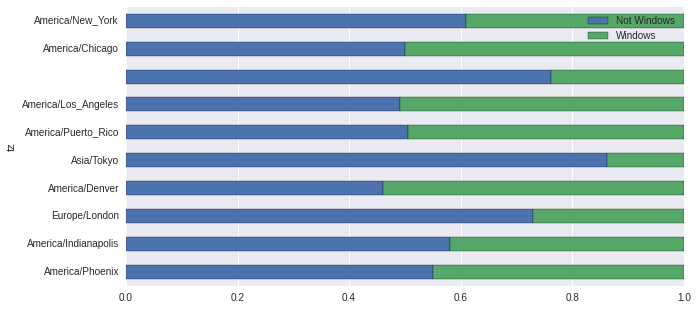

In [9]:
# 看比例而不看数据
count_subset.div(count_subset.sum(1), axis=0).plot(kind='barh', stacked=True, figsize=(10, 5))

## 分析电影评分数据

In [10]:
# 数据来源 http://grouplens.org/datasets/movielens/1m/
# 用户数据
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('ml-1m/users.dat', sep='::', header=None, names=unames, engine='python')
# 评分数据
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python')
# 电影数据
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('ml-1m/movies.dat', sep='::', header=None, names=mnames, engine='python')
# 合并为最终数据
mldata = pd.merge(pd.merge(ratings, users), movies)

In [11]:
# 使用数据
mean_ratings = mldata.pivot_table('rating', index='title', columns=['gender'], aggfunc='mean') # 得到每部电影按性别划分的评分标准

In [12]:
# 以title分组的rating
# 过滤出至少有250条评分记录的电影数据
ratings_by_title = mldata.groupby('title').size()
active_titles = ratings_by_title.index[ratings_by_title >= 250]
mean_ratings = mean_ratings.ix[active_titles]

In [26]:
# 女性最喜欢的N部电影
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings[:10]

gender,F,M,diff
title,,,
"Close Shave, A (1995)",4.644444,4.473795,-0.170650
"Wrong Trousers, The (1993)",4.588235,4.478261,-0.109974
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589,-0.108060
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075,-0.178032
Schindler's List (1993),4.562602,4.491415,-0.071187
"Shawshank Redemption, The (1994)",4.539075,4.560625,0.021550
"Grand Day Out, A (1992)",4.537879,4.293255,-0.244624
To Kill a Mockingbird (1962),4.536667,4.372611,-0.164055
Creature Comforts (1990),4.513889,4.272277,-0.241612


In [14]:
# 分歧最大的电影
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']
sort_by_diff = mean_ratings.dropna().sort_values(by='diff', ascending=False)
sort_by_diff[:10]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


In [15]:
# 不考虑性别因素分歧最大的电影列表
mldata.groupby('title')['rating'].std().ix[active_titles].sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## 分析新生儿姓名数据

In [16]:
# 数据来源： https://www.ssa.gov/oact/babynames/limits.html
from glob import glob
import re

year_ptn = re.compile(r'\d+')
pieces = []
for file_path in glob('names/*.txt'):
    names_year = pd.read_csv(file_path, names=['name', 'sex', 'births'])
    names_year['year'] = int(year_ptn.search(file_path).group())
    pieces.append(names_year)

names = pd.concat(pieces, ignore_index=True) # ignore_index=True 之后将不会返回原始行号

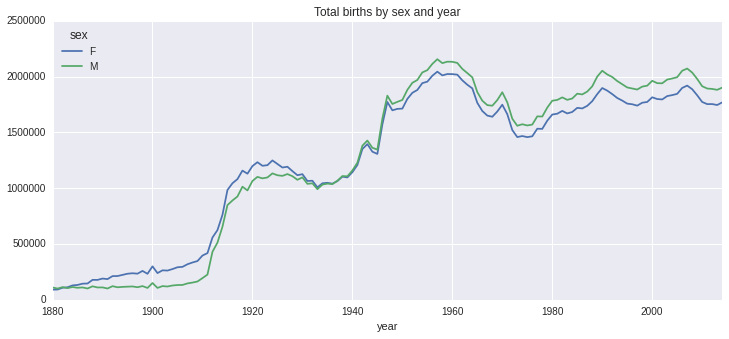

In [17]:
total_births = names.pivot_table('births', index='year', columns=['sex'], aggfunc=sum)
total_births.plot(title='Total births by sex and year', figsize=(12, 5))

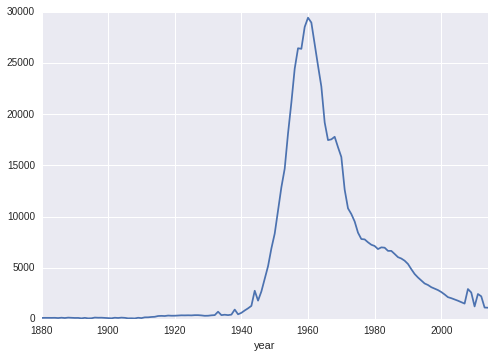

In [18]:
# 某个名字在历史上的出生人数
names[names.name == 'Mark'].pivot_table('births', index='year').plot()

In [19]:
# 指定名字的婴儿出生数占总出生数的比例
def add_prop(group):
    births = group.births.astype(float)
    group['prop'] = births/births.sum()
    
    return group

names = names.groupby(['year', 'sex']).apply(add_prop) # seems "map"?
# 有效性检查，所有名字的比例之和为1
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

In [20]:
# 取sex/year组合的前1000个名字
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

In [21]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13797e90d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f13796a89d0>], dtype=object)

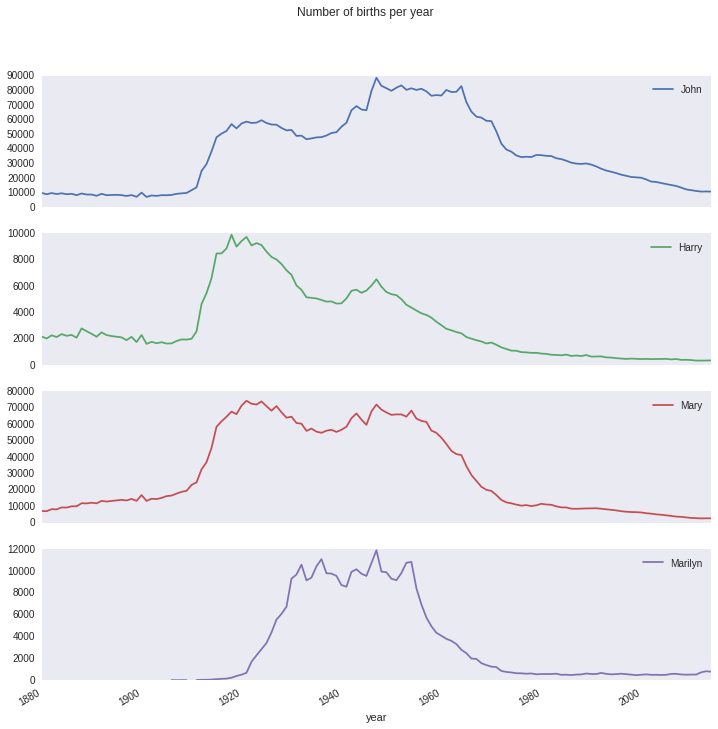

In [22]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12, 12), grid=False, title='Number of births per year')

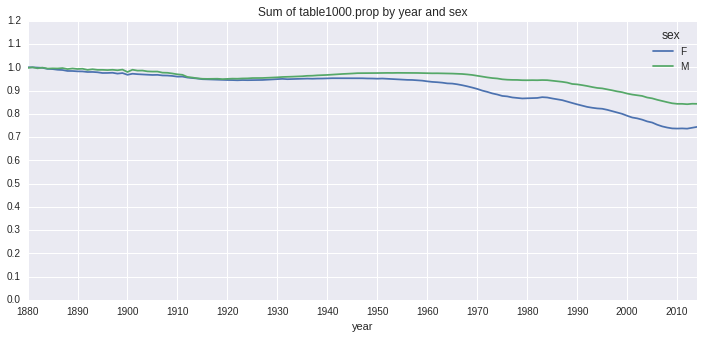

In [23]:
# top 1000姓名的新生儿占全部新生儿的比例
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13),
           figsize=(12, 5),
           xticks=range(1880, 2020, 10))

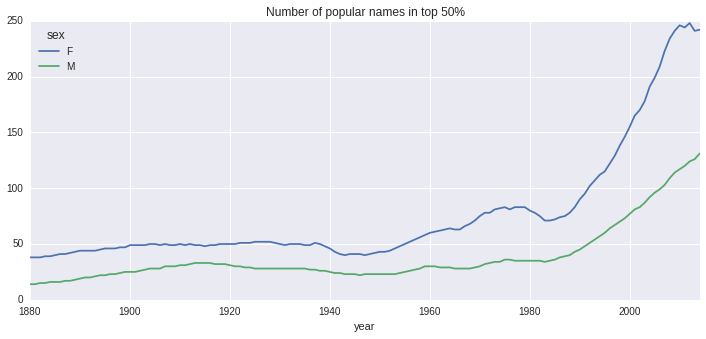

In [24]:
# 50%人数所需要的名字数
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex').astype(int)
diversity.plot(title='Number of popular names in top 50%', figsize=(12, 5))

In [25]:
top1000.name.unique()

array(['Mary', 'Anna', 'Emma', ..., 'Reyansh', 'Boden', 'Ayan'], dtype=object)